=== IGNITION LOCATION DEBUGGING ===

1. CHECKING IGNITION MASK:
   Mask shape: (400, 400)
   Mask data type: float32
   Mask min/max: 1.0 / 1.0
   Unique values: [1.]
   Number of ignitable pixels (>0): 160000
   Number of pixels = 0: 0
   Number of pixels < 0: 0
   With EDGEBUFFER=50m (~1.7 pixels), expected ignitable area: ~396x396 = 156816
   Edge pixel values:
     Top row: [1. 1. 1. 1. 1.] ...
     Bottom row: [1. 1. 1. 1. 1.] ...
     Left col: [1. 1. 1. 1. 1.] ...
     Right col: [1. 1. 1. 1. 1.] ...


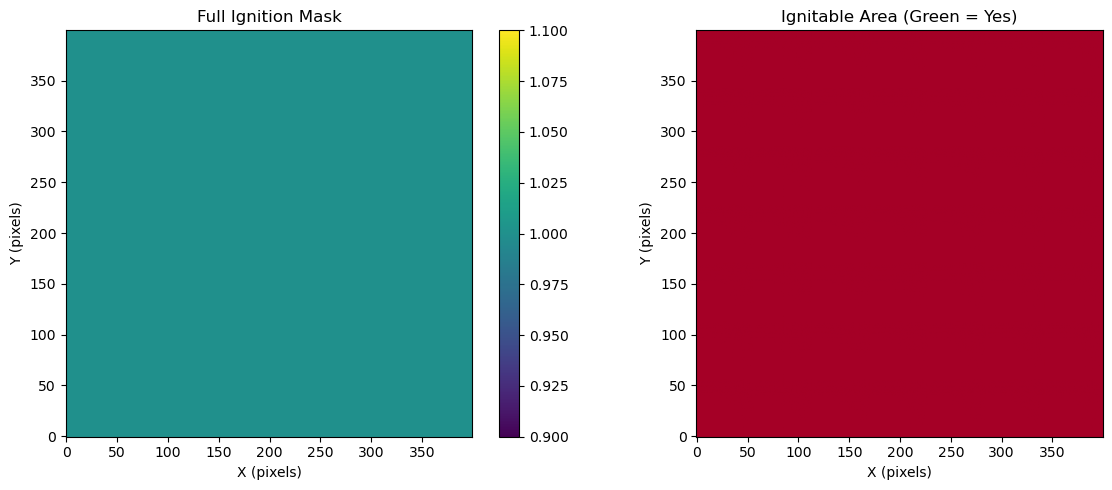

   Value at (199, 200): 1.0

2. CHECKING DOMAIN:
   Domain shape: (400, 400)
   Domain bounds: BoundingBox(left=-6000.0, bottom=-6000.0, right=6000.0, top=6000.0)
   Transform: | 30.00, 0.00,-6000.00|
| 0.00,-30.00, 6000.00|
| 0.00, 0.00, 1.00|
   Center pixel coordinates: (200, 200)

3. ANALYZING IGNITION PATTERNS:
   Case 1: (199, 200) - Min time: 30.0s
   Case 2: (223, 192) - Min time: 30.0s
   Case 3: (199, 200) - Min time: 30.0s
   Case 4: (189, 105) - Min time: 30.0s
   Case 5: (199, 200) - Min time: 30.0s
   Case 6: (132, 163) - Min time: 30.0s
   Case 7: (199, 200) - Min time: 30.0s
   Case 8: (199, 200) - Min time: 30.0s
   Case 9: (205, 148) - Min time: 30.0s
   Case 10: (199, 200) - Min time: 30.0s

4. CLUSTERING ANALYSIS:
   Unique ignition locations and their frequencies:
   ✅ (132, 163): 1 time
   ✅ (189, 105): 1 time
   ⚠️  (199, 200): 6 times
   ✅ (205, 148): 1 time
   ✅ (223, 192): 1 time
   Approximate domain center: (111, 100)

5. IGNITION DISTRIBUTION PLOT:


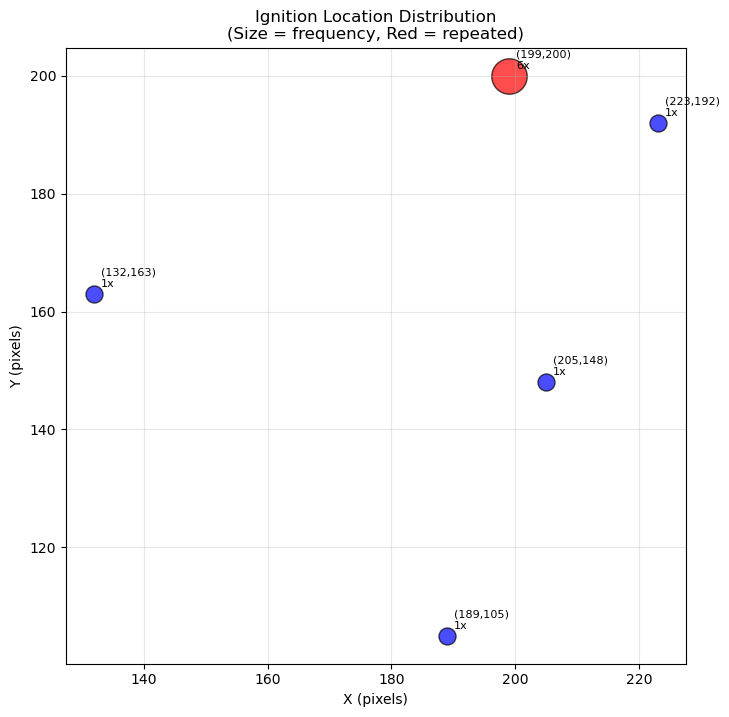


6. RECOMMENDATIONS:
   - If ignition mask has limited >0 pixels, that could cause clustering
   - If (199,200) is always used, it might be a fallback/default location
   - Check ELMFIRE logs for any warnings about ignition placement
   - Try creating a different ignition mask pattern to test


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
import os

print("=== IGNITION LOCATION DEBUGGING ===\n")

# 1. Check the ignition mask
print("1. CHECKING IGNITION MASK:")
mask_file = './inputs/ignition_mask.tif'
if os.path.exists(mask_file):
    with rasterio.open(mask_file) as src:
        mask_data = src.read(1)
        print(f"   Mask shape: {mask_data.shape}")
        print(f"   Mask data type: {mask_data.dtype}")
        print(f"   Mask min/max: {np.min(mask_data)} / {np.max(mask_data)}")
        print(f"   Unique values: {np.unique(mask_data)}")
        print(f"   Number of ignitable pixels (>0): {np.sum(mask_data > 0)}")
        print(f"   Number of pixels = 0: {np.sum(mask_data == 0)}")
        print(f"   Number of pixels < 0: {np.sum(mask_data < 0)}")
        print(f"   With EDGEBUFFER=50m (~1.7 pixels), expected ignitable area: ~396x396 = {396*396}")
        
        # Check edge effects
        print(f"   Edge pixel values:")
        print(f"     Top row: {mask_data[0, :5]} ...")
        print(f"     Bottom row: {mask_data[-1, :5]} ...")
        print(f"     Left col: {mask_data[:5, 0]} ...")
        print(f"     Right col: {mask_data[:5, -1]} ...")
        
        # Show where the mask allows ignitions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Full mask
        im1 = ax1.imshow(mask_data, origin='lower', cmap='viridis')
        ax1.set_title('Full Ignition Mask')
        ax1.set_xlabel('X (pixels)')
        ax1.set_ylabel('Y (pixels)')
        plt.colorbar(im1, ax=ax1)
        
        # Ignitable area only
        ignitable = mask_data > 0
        ax2.imshow(ignitable, origin='lower', cmap='RdYlGn')
        ax2.set_title('Ignitable Area (Green = Yes)')
        ax2.set_xlabel('X (pixels)')
        ax2.set_ylabel('Y (pixels)')
        
        plt.tight_layout()
        plt.show()
        
        # Check if (199, 200) is special
        if mask_data.shape[0] > 200 and mask_data.shape[1] > 199:
            center_val = mask_data[200, 199]  # Note: array indexing is [y, x]
            print(f"   Value at (199, 200): {center_val}")
        
else:
    print("   ❌ Ignition mask file not found!")

# 2. Check domain size and coordinates
print("\n2. CHECKING DOMAIN:")
# Try to read any input file to check domain size
input_files = glob.glob('./inputs/*.tif')
if input_files:
    with rasterio.open(input_files[0]) as src:
        print(f"   Domain shape: {src.shape}")
        print(f"   Domain bounds: {src.bounds}")
        print(f"   Transform: {src.transform}")
        print(f"   Center pixel coordinates: ({src.shape[1]//2}, {src.shape[0]//2})")

# 3. Analyze time of arrival files for ignition patterns
print("\n3. ANALYZING IGNITION PATTERNS:")
time_files = sorted(glob.glob('./outputs/time_of_arrival_*.tif'))

ignition_coords = []
for i, file in enumerate(time_files[:10]):
    with rasterio.open(file) as src:
        data = src.read(1)
        # Replace nodata with nan
        data = np.where(data == -9999, np.nan, data)
        data = np.where(data == src.nodata, np.nan, data) if src.nodata else data
        
        # Find ignition (minimum time)
        if not np.all(np.isnan(data)):
            min_idx = np.nanargmin(data)
            y_idx, x_idx = np.unravel_index(min_idx, data.shape)
            min_time = data[y_idx, x_idx]
            ignition_coords.append((x_idx, y_idx, min_time))
            print(f"   Case {i+1}: ({x_idx}, {y_idx}) - Min time: {min_time:.1f}s")
        else:
            print(f"   Case {i+1}: All NaN data!")

# 4. Check for clustering patterns
print("\n4. CLUSTERING ANALYSIS:")
if len(ignition_coords) > 0:
    coords_array = np.array([(x, y) for x, y, t in ignition_coords])
    unique_coords, counts = np.unique(coords_array, axis=0, return_counts=True)
    
    print("   Unique ignition locations and their frequencies:")
    for coord, count in zip(unique_coords, counts):
        if count > 1:
            print(f"   ⚠️  ({coord[0]}, {coord[1]}): {count} times")
        else:
            print(f"   ✅ ({coord[0]}, {coord[1]}): {count} time")
    
    # Check if (199, 200) is domain center
    domain_center_x = coords_array[:, 0].max() // 2
    domain_center_y = coords_array[:, 1].max() // 2
    print(f"   Approximate domain center: ({domain_center_x}, {domain_center_y})")
    
    if (199, 200) == (domain_center_x, domain_center_y) or abs(199 - domain_center_x) <= 1:
        print("   🔍 (199, 200) appears to be near domain center - possible default fallback location")

# 5. Plot ignition distribution
if len(ignition_coords) > 0:
    print("\n5. IGNITION DISTRIBUTION PLOT:")
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot all ignitions with different colors/sizes
    coords_array = np.array([(x, y) for x, y, t in ignition_coords])
    
    # Count occurrences at each location
    unique_coords, inverse_indices, counts = np.unique(coords_array, axis=0, return_inverse=True, return_counts=True)
    
    # Create scatter plot with size based on frequency
    for i, (coord, count) in enumerate(zip(unique_coords, counts)):
        x, y = coord
        size = 50 + count * 100  # Base size + frequency multiplier
        color = 'red' if count > 1 else 'blue'
        ax.scatter(x, y, s=size, c=color, alpha=0.7, edgecolors='black')
        ax.annotate(f'({x},{y})\n{count}x', (x, y), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_title('Ignition Location Distribution\n(Size = frequency, Red = repeated)')
    ax.grid(True, alpha=0.3)
    plt.show()

print("\n6. RECOMMENDATIONS:")
print("   - If ignition mask has limited >0 pixels, that could cause clustering")
print("   - If (199,200) is always used, it might be a fallback/default location")  
print("   - Check ELMFIRE logs for any warnings about ignition placement")
print("   - Try creating a different ignition mask pattern to test")

In [2]:
# Add this to see what's actually in the mask
print(f"Mask data sample (center 10x10):")
print(mask_data[195:205, 195:205])

print(f"Are any values exactly > 0? {np.any(mask_data > 0)}")
print(f"Are any values exactly == 1? {np.any(mask_data == 1)}")
print(f"Data type issues? {mask_data.dtype}")

Mask data sample (center 10x10):
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Are any values exactly > 0? True
Are any values exactly == 1? True
Data type issues? float32


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
import os
from pathlib import Path

# Configuration
outputs_dir = './outputs'
inputs_dir = './inputs'

# Helper function to read raster
def read_raster(filepath):
    """Read a raster file and return data, metadata"""
    with rasterio.open(filepath) as src:
        data = src.read(1)
        # Handle nodata values
        if src.nodata is not None:
            data = np.where(data == src.nodata, np.nan, data)
        data = np.where(data == -9999, np.nan, data)
        return data, src.meta

# Helper function to find ignition locations
def find_ignition_locations(time_arrival_files):
    """Find ignition locations from time of arrival rasters"""
    ignition_locations = []
    
    for i, file in enumerate(time_arrival_files[:10]):  # Only first 10
        data, _ = read_raster(file)
        # Find location of minimum time (ignition point)
        min_idx = np.nanargmin(data)
        y_idx, x_idx = np.unravel_index(min_idx, data.shape)
        ignition_locations.append((x_idx, y_idx, i+1))
    
    return ignition_locations

print("=== ELMFIRE Monte Carlo Output Analysis ===\n")

=== ELMFIRE Monte Carlo Output Analysis ===



1. CHECKING OUTPUT FILES:
   Time of arrival files: 100
   Fire line intensity files: 100
   Spread velocity files: 100

2. FINDING IGNITION LOCATIONS:
   Found 10 ignition locations


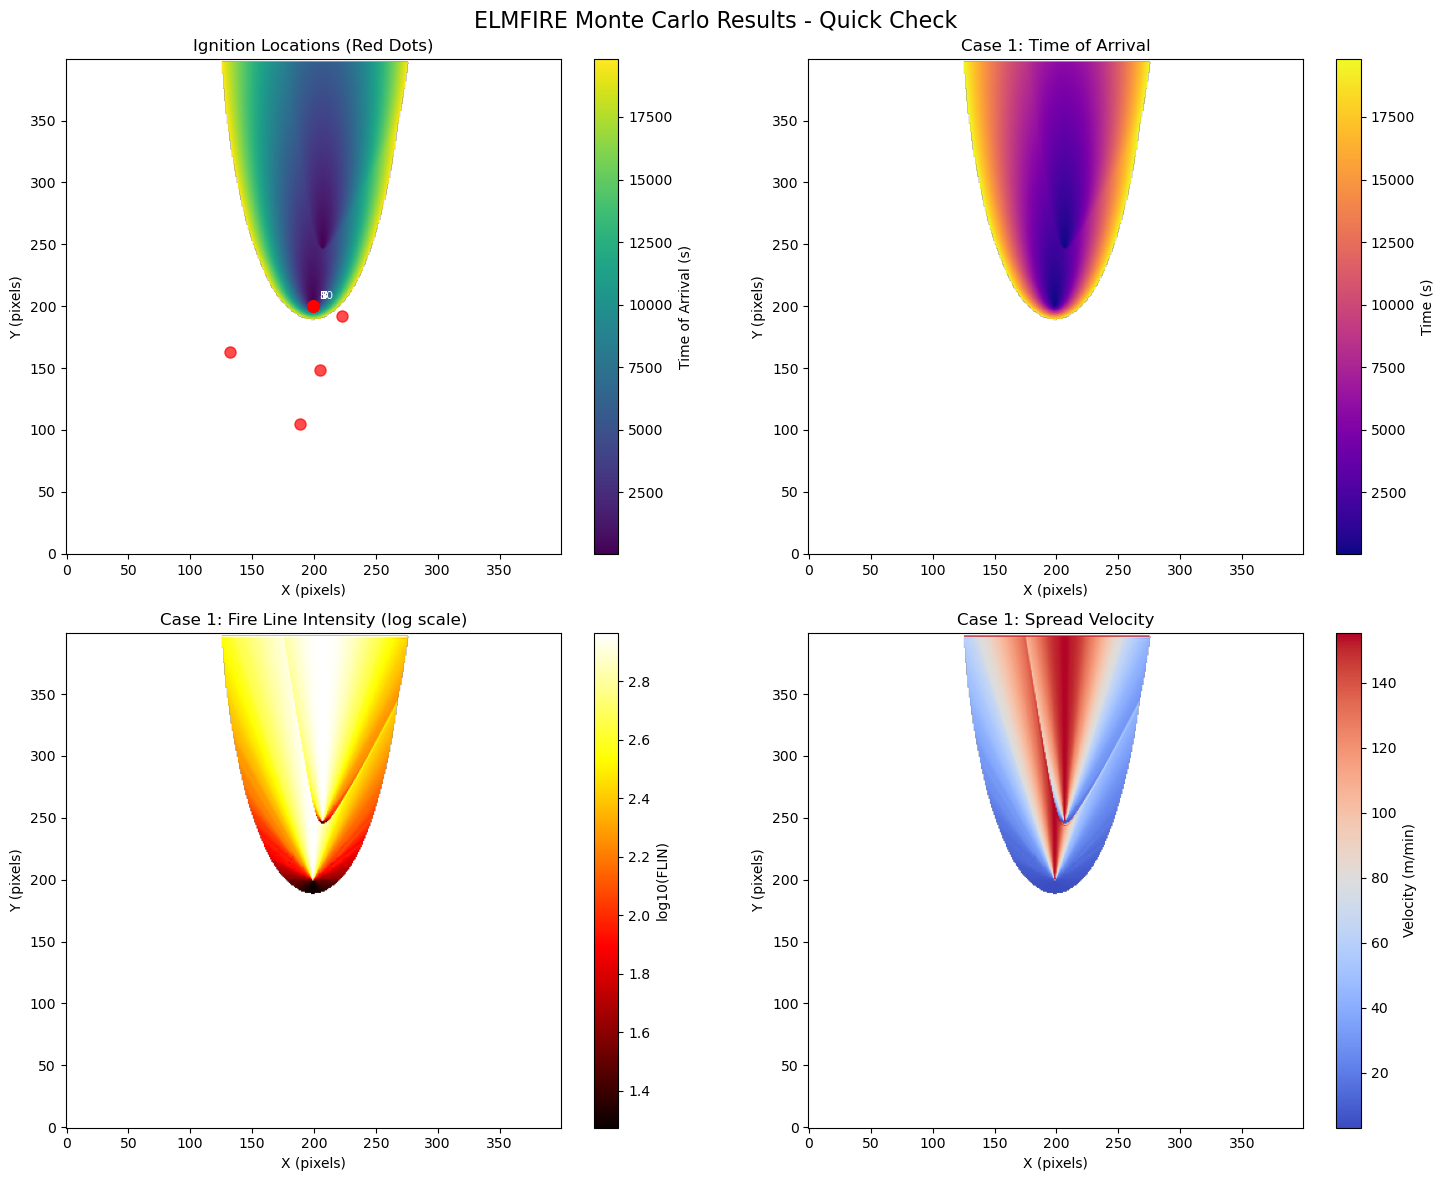

In [4]:
# 1. Check what files we have
print("1. CHECKING OUTPUT FILES:")
time_files = sorted(glob.glob(os.path.join(outputs_dir, 'time_of_arrival_*.tif')))
flin_files = sorted(glob.glob(os.path.join(outputs_dir, 'flin_*.tif')))
vs_files = sorted(glob.glob(os.path.join(outputs_dir, 'vs_*.tif')))

print(f"   Time of arrival files: {len(time_files)}")
print(f"   Fire line intensity files: {len(flin_files)}")
print(f"   Spread velocity files: {len(vs_files)}")

if len(time_files) == 0:
    print("❌ No output files found! Check your outputs directory path.")
    exit()

# 2. Find ignition locations
print("\n2. FINDING IGNITION LOCATIONS:")
ignition_locs = find_ignition_locations(time_files)
print(f"   Found {len(ignition_locs)} ignition locations")

# 3. Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ELMFIRE Monte Carlo Results - Quick Check', fontsize=16)
# Plot 1: All ignition locations on first time_of_arrival
if len(time_files) > 0:
    first_time_data, meta = read_raster(time_files[0])
    
    ax = axes[0, 0]
    im1 = ax.imshow(first_time_data, cmap='viridis', origin='lower')
    
    # Plot all ignition locations
    for x, y, case_num in ignition_locs:
        ax.plot(x, y, 'ro', markersize=8, alpha=0.7)
        ax.annotate(f'{case_num}', (x, y), xytext=(5, 5), 
                   textcoords='offset points', color='white', fontsize=8)
    
    ax.set_title('Ignition Locations (Red Dots)')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax, label='Time of Arrival (s)')

# Plot 2: Time of arrival for first case
if len(time_files) > 0:
    first_case_data, _ = read_raster(time_files[0])
    
    ax = axes[0, 1]
    im2 = ax.imshow(first_case_data, cmap='plasma', origin='lower')
    ax.set_title('Case 1: Time of Arrival')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax, label='Time (s)')

# Plot 3: Fire line intensity for first case
if len(flin_files) > 0:
    first_flin_data, _ = read_raster(flin_files[0])
    
    ax = axes[1, 0]
    # Use log scale for FLIN since it can vary widely
    flin_log = np.log10(np.maximum(first_flin_data, 1))
    im3 = ax.imshow(flin_log, cmap='hot', origin='lower')
    ax.set_title('Case 1: Fire Line Intensity (log scale)')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    plt.colorbar(im3, ax=ax, label='log10(FLIN)')

# Plot 4: Spread velocity for first case
if len(vs_files) > 0:
    first_vs_data, _ = read_raster(vs_files[0])
    
    ax = axes[1, 1]
    im4 = ax.imshow(first_vs_data, cmap='coolwarm', origin='lower')
    ax.set_title('Case 1: Spread Velocity')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    plt.colorbar(im4, ax=ax, label='Velocity (m/min)')

plt.tight_layout()
plt.show()

In [3]:
# print the ignition locations
print("\nIgnition Locations (X, Y, Case Number):")
for x, y, case_num in ignition_locs:
    print(f"   Case {case_num}: ({x}, {y})")
print("\nAnalysis complete! Check the plots for results.")


Ignition Locations (X, Y, Case Number):
   Case 1: (199, 200)
   Case 2: (199, 100)
   Case 3: (199, 200)
   Case 4: (199, 200)
   Case 5: (199, 200)
   Case 6: (223, 192)
   Case 7: (223, 192)
   Case 8: (319, 187)
   Case 9: (15, 184)
   Case 10: (199, 200)

Analysis complete! Check the plots for results.


Ignition mask - Min: 1.0, Max: 1.0
Unique values: [1.]


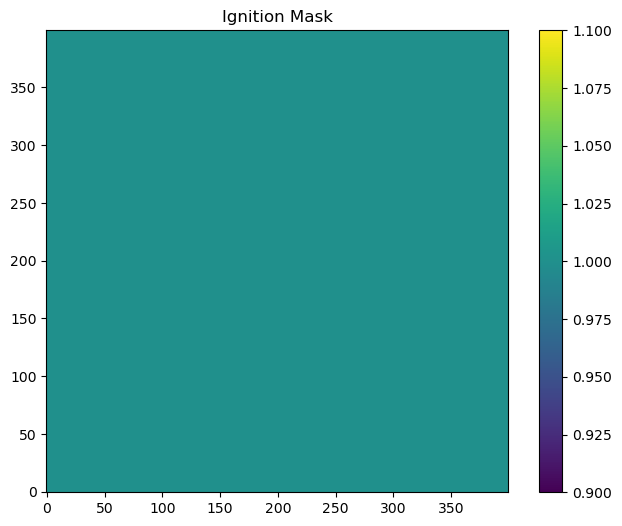

In [20]:
# Add this to your notebook to inspect the ignition mask
mask_data, _ = read_raster('./docker_shared_folder/06-multouts/inputs/ignition_mask.tif')
print(f"Ignition mask - Min: {np.nanmin(mask_data)}, Max: {np.nanmax(mask_data)}")
print(f"Unique values: {np.unique(mask_data[~np.isnan(mask_data)])}")
plt.figure(figsize=(8, 6))
plt.imshow(mask_data, origin='lower')
plt.title('Ignition Mask')
plt.colorbar()
plt.show()

In [21]:
# 4. Print statistics for first case
print("\n3. STATISTICS FOR CASE 1:")
if len(time_files) > 0:
    data, _ = read_raster(time_files[0])
    print(f"   Time of Arrival - Min: {np.nanmin(data):.1f}s, Max: {np.nanmax(data):.1f}s, Mean: {np.nanmean(data):.1f}s")

if len(flin_files) > 0:
    data, _ = read_raster(flin_files[0])
    print(f"   Fire Line Intensity - Min: {np.nanmin(data):.1f}, Max: {np.nanmax(data):.1f}, Mean: {np.nanmean(data):.1f}")

if len(vs_files) > 0:
    data, _ = read_raster(vs_files[0])
    print(f"   Spread Velocity - Min: {np.nanmin(data):.3f}, Max: {np.nanmax(data):.3f}, Mean: {np.nanmean(data):.3f}")

# 5. Sample input parameters for Case 1
print("\n4. INPUT PARAMETERS (Case 1 - these should be constant across landscape):")

# Check if input files exist
input_params = [
    ('ws', 'Wind Speed (mph)'),
    ('wd', 'Wind Direction (deg)'),
    ('m1', '1-hr Moisture (%)'),
    ('m10', '10-hr Moisture (%)'),
    ('m100', '100-hr Moisture (%)'),
    ('slp', 'Slope (deg)'),
    ('asp', 'Aspect (deg)'),
    ('fbfm40', 'Fuel Model'),
    ('cc', 'Canopy Cover (%)'),
    ('ch', 'Canopy Height (10m units)'),
    ('cbh', 'Canopy Base Height (10m units)'),
    ('cbd', 'Canopy Bulk Density (100*kg/m3)'),
    ('adj', 'Spread Rate Adjustment')
]

for param_name, description in input_params:
    file_path = os.path.join(inputs_dir, f'{param_name}.tif')
    if os.path.exists(file_path):
        try:
            data, _ = read_raster(file_path)
            # Sample a few values (should be constant for global perturbation)
            sample_vals = data[~np.isnan(data)][:5] if len(data[~np.isnan(data)]) > 0 else [np.nan]
            mean_val = np.nanmean(data)
            print(f"   {description}: {mean_val:.2f} (sample: {sample_vals[0]:.2f})")
        except Exception as e:
            print(f"   {description}: Error reading file - {e}")
    else:
        print(f"   {description}: File not found")

# 6. Fire area summary
print("\n5. FIRE AREA SUMMARY:")
areas = []
for i, file in enumerate(time_files):
    try:
        data, meta = read_raster(file)
        # Count burned pixels (not NaN)
        burned_pixels = np.sum(~np.isnan(data))
        # Convert to area (30m x 30m pixels to acres)
        pixel_area_m2 = 30 * 30  # 900 m2 per pixel
        area_acres = (burned_pixels * pixel_area_m2) / 4047  # m2 to acres
        areas.append(area_acres)
        if i < 10:  # Only print first 10
            print(f"   Case {i+1:2d}: {area_acres:8.1f} acres ({burned_pixels:6d} pixels)")
    except Exception as e:
        print(f"   Case {i+1:2d}: Error - {e}")

if areas:
    print(f"\n   Total cases: {len(areas)}")
    print(f"   Area range: {min(areas):.1f} - {max(areas):.1f} acres")
    print(f"   Mean area: {np.mean(areas):.1f} ± {np.std(areas):.1f} acres")

print("\n✅ Analysis complete!")


3. STATISTICS FOR CASE 1:
   Time of Arrival - Min: 30.0s, Max: 19804.2s, Mean: 13193.8s
   Fire Line Intensity - Min: 24.7, Max: 1218.3, Mean: 916.1
   Spread Velocity - Min: 1.646, Max: 81.130, Mean: 61.007

4. INPUT PARAMETERS (Case 1 - these should be constant across landscape):
   Wind Speed (mph): 15.00 (sample: 15.00)
   Wind Direction (deg): 0.00 (sample: 0.00)
   1-hr Moisture (%): 3.00 (sample: 3.00)
   10-hr Moisture (%): 4.00 (sample: 4.00)
   100-hr Moisture (%): 5.00 (sample: 5.00)
   Slope (deg): 0.00 (sample: 0.00)
   Aspect (deg): 0.00 (sample: 0.00)
   Fuel Model: 102.00 (sample: 102.00)
   Canopy Cover (%): 0.00 (sample: 0.00)
   Canopy Height (10m units): 0.00 (sample: 0.00)
   Canopy Base Height (10m units): 0.00 (sample: 0.00)
   Canopy Bulk Density (100*kg/m3): 0.00 (sample: 0.00)
   Spread Rate Adjustment: 1.00 (sample: 1.00)

5. FIRE AREA SUMMARY:
   Case  1:   3851.7 acres ( 17320 pixels)
   Case  2:   4557.2 acres ( 20492 pixels)
   Case  3:   3093.4 acres (